* **1. Introduction**
* **2. Data preparation**
    * 2.1 Load data
    * 2.2 Check for null and missing values
    * 2.3 Normalization
    * 2.4 Reshape
    * 2.5 Label encoding
    * 2.6 Split training and valdiation set
* **3. CNN**

* **4. Evaluate the model**

* **5. Prediction and submition**


# 1. Introduction


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. Data preparation
## 2.1 Load data

In [2]:
# >>>>>填写<<<< 利用pandas的load_csv函数，读取我们的train 和 test数据集合 变量已经给出 >>>>>填写<<<< ######
train = pd.read_csv("subset_train.csv")
test = pd.read_csv("Small_test.csv")
#####train validation test(完全独立的，与训练过程无关的)

3    227
7    220
2    220
1    218
6    214
9    209
4    209
5    201
0    199
8    183
Name: label, dtype: int64

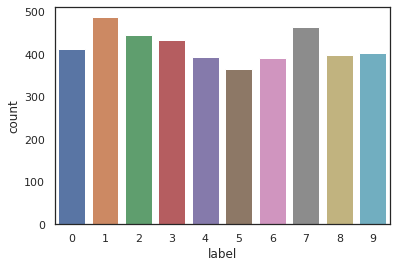

In [3]:
# >>>>>填写<<<< 利用pandas的header选择，将label列传递给Y_train >>>>>填写<<<< 
Y_train = train["label"]
Y_test = test['label']
# 因为train.csv中，第一列label在上述代码已经传递给Y_label，这里对于x_train 我们不需要训练集的第一列 #####
X_train = train.drop(labels = ["label"],axis = 1) 
X_test = test.drop(labels = ["label"],axis = 1)


g = sns.countplot(Y_train)

Y_train.value_counts()
Y_train
Y_test.value_counts()


## We have similar counts for the 10 digits.

## 2.2 Check for null and missing values

In [4]:
# 检查训练数据是否有空值
X_train.isnull().any().describe() 

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
# >>>>填写<<<< 检查训练数据是否有空值 >>>>填写<<<< ###
X_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].
标准化，将灰度值 0-255 映射到0 - 1区间

In [6]:
# Normalize the data
X_train = X_train / 255.0
###### >>>填写<<< 标准化测试集合 #######
X_test = X_test / 255.0

## 2.3 Reshape

In [7]:
# >>>>填写<<<<< 利用 reshape 函数， 将X_train变换成 (height = 28px, width = 28px , canal = 1)>>>>填写<<<<< ######
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1) 


Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. 

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices. 

## 2.5 Label encoding

In [8]:
# 利用0 1编码 将0-9数字标签编码成10维向量 (ex : 9 -> [0,0,0,0,0,0,0,0,0,1])
##
Y_train = to_categorical(Y_train, num_classes = 10)
Y_test = to_categorical(Y_test, num_classes = 10)
## one-hot encoding

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.6 Split training and valdiation set 

In [9]:
# Set the random seed
random_seed = 2

In [10]:
# 将训练集合按照9:1 分成训练集合 和验证集合 validation 10折交叉验证 10-fold validation  ####
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

We can get a better sense for one of these examples by visualising the image and looking at the label.

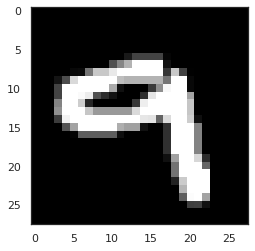

In [11]:
# Some examples #x-train里面第一个sample的 0:最大 0:最大 0 [:,:,0] 
g = plt.imshow(X_train[0][:,:,0],cmap='gray') #plt为什么把灰度可以生

# 3. CNN
## 3.1 Define the model

In [12]:
#####  填写 batch_size epoch 请根据traindata 总量填写合适的值 ####
##### 我们的分配数量num_classes,提示 我们的任务是手写体0-9的识别 ####### 

batch_size = 37
num_classes = 10
epochs = 10

input_shape = (28,28,1)

#构建CNN 模型 这里我们利用Sequential 序列累加 ######
model = Sequential()
## 第一个 卷积层 32个kernel kernel大小3*3 输出的激活函数relu kernel利用 He-正态分布 生成  ####
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))

###  请自行构建第二个卷积层，此时kernel的初始尝试用全零初始/全1初始/正态初始
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
### 构建一个最大池化层 
model.add(MaxPool2D((2, 2),strides=2))

model.add(Dropout(0.20))
###  在下述卷积层内 构建一个padding, 在之后构建一个kernel size = 2 *2 的池化层 
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
###  构建一个全联接 其中包含128个神经元 并使用relu激活函数


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

###  构建一个全联接，该全联接需要用特定的激活函数和适当的神经元个数 来实现我们的分类目标  提示：我们有多少个标签？什么激活适合最后的输出？
model.add(Dense(num_classes, activation='softmax'))


In [13]:
### 运行model.summary（）回答下列问题 第二天课上一起讨论 ####
### 能否画出这个模型的概括图?  >>>

### 这个模型有几个卷积层？ 3
### 这个模型最大的参数量是哪一层？full - connection
### 第一层卷积层为什么有320个实际变量需要调节       32 * 9 + 32 * 1 (W,bias)  y=wx+b


#最后一层 max——pooling完 有64个6*6 feature maps 64*6*6 = 2304

### para = 2304*128 + 128 #128个w,b

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)         

In [14]:
#优化器  尝试使用不同的优化器 至少以下三种
## 中文参考 https://keras.io/zh/optimizers/
## 
## SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
## RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
## Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

### 将模型compile 编译
### 调节loss 参数，即loss function
### mean_squared_error
### categorical_crossentropy/为什么不用binary_crossentropy
### mean_absolute_error 
model.compile(optimizer = optimizer , loss = "categorical_crossentropy"   , metrics=["accuracy"])

### training 过程中的 自动调节函数
### Reduce LR On Plateau = 减少学习率，当某一个参数达到一个平台期 自动的 把上面优化器中的 lr 减小

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
# 训练模型 注意填写缺失参数 记得用变量形式填写
history = model.fit(X_train,Y_train, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_val,Y_val),callbacks=[learning_rate_reduction])



Train on 3780 samples, validate on 420 samples
Epoch 1/10
3780/3780 [==============================] - 18s 5ms/step - loss: 0.5881 - accuracy: 0.8190 - val_loss: 0.3440 - val_accuracy: 0.9048
Epoch 2/10
  74/3780 [..............................] - ETA: 7s - loss: 0.1839 - accuracy: 0.9595 

/home/zzk/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3780/3780 [==============================] - 10s 3ms/step - loss: 0.2044 - accuracy: 0.9389 - val_loss: 0.1865 - val_accuracy: 0.9452
Epoch 3/10
3780/3780 [==============================] - 7s 2ms/step - loss: 0.1278 - accuracy: 0.9601 - val_loss: 0.1424 - val_accuracy: 0.9524
Epoch 4/10
3780/3780 [==============================] - 8s 2ms/step - loss: 0.0895 - accuracy: 0.9725 - val_loss: 0.1736 - val_accuracy: 0.9405
Epoch 5/10
3780/3780 [==============================] - 8s 2ms/step - loss: 0.0717 - accuracy: 0.9796 - val_loss: 0.1286 - val_accuracy: 0.9643
Epoch 6/10
3780/3780 [==============================] - 9s 2ms/step - loss: 0.0614 - accuracy: 0.9812 - val_loss: 0.0987 - val_accuracy: 0.9762
Epoch 7/10
3780/3780 [==============================] - 8s 2ms/step - loss: 0.0514 - accuracy: 0.9852 - val_loss: 0.1232 - val_accuracy: 0.9643
Epoch 8/10
3780/3780 [==============================] - 9s 2ms/step - loss: 0.0472 - accuracy: 0.9833 - val_loss: 0.1433 - val_accuracy: 0.9405
Ep

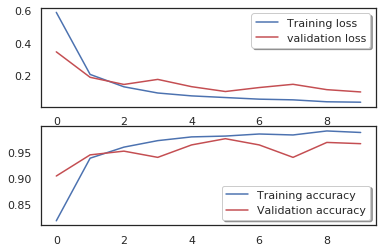

In [16]:
# 生成学习曲线 和损失函数 随着epoch的变化曲线
# 模型的学习效果怎么样？ 能找到适合的epoch吗？
# 简单的评价标准应该用什么？
# 尝试改变模型参数 生成不同的学习曲线 比较
# 提示 从epoch>优化器>损失函数>学习率>dropout有无 依次调试 
fig, ax = plt.subplots(2,1)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

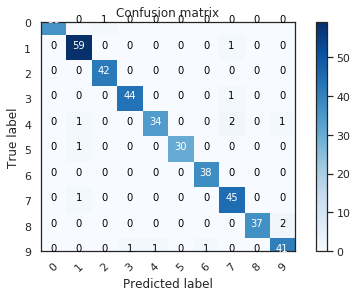

In [17]:
# 生成10标签混淆矩阵

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

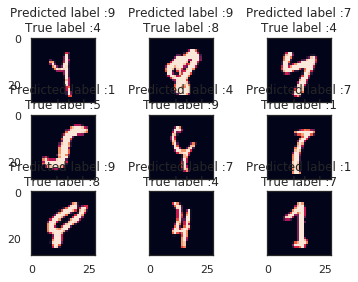

In [18]:
### 打印出认错的数字

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 9 errors 
most_important_errors = sorted_dela_errors[-9:]

# Show the top 9 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [19]:
#optional 计算每个标签的tpr fpr
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict(X_test)
for i in range(num_classes):
     fpr[i], tpr[i], _ = roc_curve(Y_test[:,i],y_score[:,i])
    # AUC Area Under the Curve
     roc_auc[i] = auc(fpr[i], tpr[i])


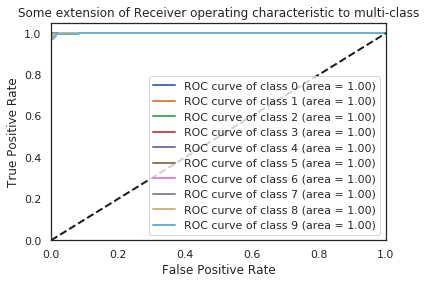

In [20]:
#画出ROC
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i],lw=2, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

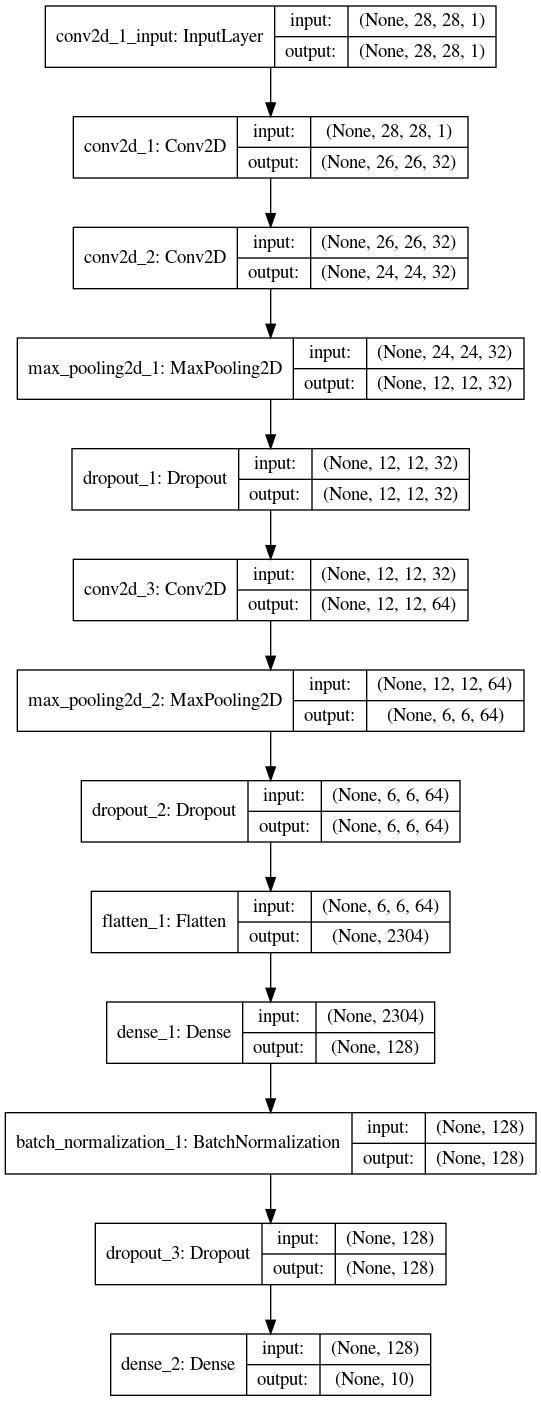

In [21]:
from keras.utils import plot_model
# 打印出模型图片 尝试自己改动模型 
plot_model(model, to_file='model.png', show_shapes=True)